In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Ellipse
from matplotlib import cm
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from scipy.stats import multivariate_normal
sns.set(style='white')
plt.set_cmap('Dark2')

# Expectation Maximization
The Expectation maximization (EM) algorithm can be used as an iterative approach to maximize the likelihood of 

# k-means Clustering
## Algorithm

## Implementation

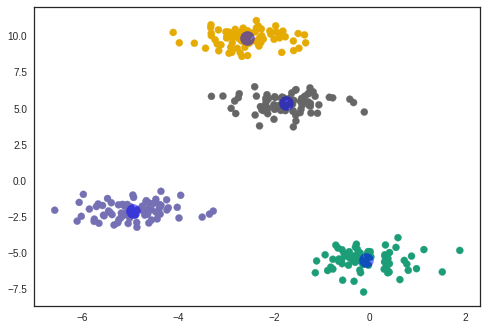

In [2]:
n_centers = 4
X, y_true = make_blobs(n_samples=300, centers=n_centers, 
                       cluster_std=0.6, random_state=50)
true_centers = np.array([X[y_true == i].mean(axis=0) for i in range(n_centers)])
# plot true assignments
plt.scatter(X[:, 0], X[:, 1], s=50, c=y_true)
plt.scatter(true_centers[:, 0], true_centers[:, 1], s=200, c='b', alpha=0.5)
plt.show()

## k-means
### initialization: randomly pick k data points and define them as initial centers

In [3]:
#### k-means
# initialization: randomly pick k data points and define them as initial centers
def random_centers(data, k, seed=None):
    """
    Random Initialization: randomly pick k data points and define them as initial centers
    
    Params
    data : array(n_data, n_features)
    k : int; number of initial centers to choose
    seed : int(optional); a random seed 
    
    Returns
    centers : array(k, n_features); randomly picked centers 
    """
    if seed:
        np.random.seed(seed)
    return data[np.random.choice(range(data.shape[0]), size=k, replace=False)]
c_init = random_centers(X, n_centers, 1)

### Calculate distance for each point to its nearest center

In [4]:
def measure_distance(data, centers):
    """
    E-Step: Calucalte the distance between data points and centers and assign each point to the closest center.
    
    Params
    data : array(n_data, n_features)
    centers : array(n_centers, n_features); centers
    
    Returns
    cluster_assignments : array(n_data, 1+n_features); Returns an array with the assigned cluster index 
    and the corresponding data point features.
    """
    n_data, n_dim = data.shape
    n_centers = centers.shape[0]
    
    distances = np.ones((1, n_data))*np.sum((data-centers[0,:])**2, axis=1)
    for j in range(n_centers-1):
        distances = np.append(distances, np.ones((1, n_data))*
                  np.sum((data-centers[j+1,:])**2, axis=1), axis=0)
        
    cluster = distances.argmin(axis=0).reshape((n_data, 1))
    cluster = np.append(cluster, data, axis=1)
    return cluster

### Relocate cluster centers to the mean of assigned data points

In [5]:
def relocate_centers(center_assignments, k):
    """
    M-Step: Relocate the cluster centers to the mean of the assigned data points.
    
    Params
    cluster_assignments : array(n_data, assigned_cluster_index + n_features)
    k : int; number of clusters
    """
    new_centers = np.array([center_assignments[:,1:][center_assignments[:,0] == i].mean(axis=0) for i in range(k)])
    return new_centers

### k-means procedure

In [6]:
def kmeans(data, center_init, max_iter = 100):
    """
    Calculate k-means algorithm
    
    Params
    data : array(n_data, n_features)
    center_init : array(n_centers, n_features); initial centers
    max_iter : int(Default = 100); number of maximum EM iterations to stop if algorithm has not converged until then 
    """
    centers = center_init
    iterations = 0
    while True:
        iterations += 1
        assignments = measure_distance(data, centers)
        new_centers = relocate_centers(assignments, centers.shape[0])
        
        if (np.all(centers == new_centers)) or iterations == max_iter:
            break
        else:
            centers = new_centers
    
    # SSE
    errors = [np.sum(np.sum((assignments[:,1:][assignments[:,0] == i] - centers[i])**2)) 
              for i in range(centers.shape[0])]
    errors = sum(errors)
          
    return centers, assignments, errors, iterations

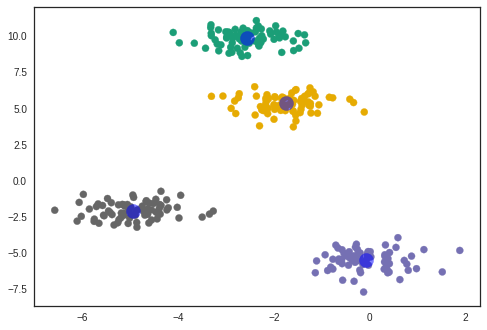

In [7]:
centers, assignments, _, _ = kmeans(X, c_init)
plt.scatter(assignments[: ,1], assignments[: ,2], s=50,  c=assignments[: ,0])
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='b', alpha=0.5)
plt.show()

### Local Minima due to bad initialization

Run 1 has SSE 207.959465126 and took 4 iterations
Run 2 has SSE 207.959465126 and took 2 iterations
Run 3 has SSE 974.878177091 and took 7 iterations
Run 4 has SSE 976.207522885 and took 15 iterations
Run 5 has SSE 207.959465126 and took 3 iterations
Run 6 has SSE 207.959465126 and took 3 iterations


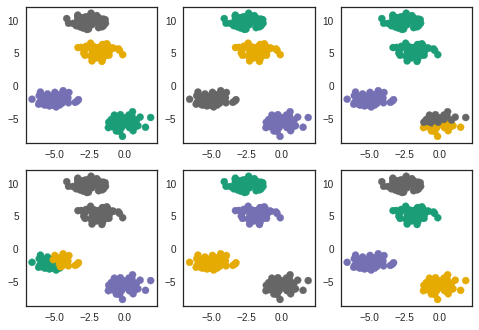

In [8]:
def plot_6_kmeans(data, n_centers, center_init_fun):
    fig, axes = plt.subplots(2, 3)
    for i in range(6):
        c_init = center_init_fun(data, n_centers, i)
        centers, assignments, errors, iterations = kmeans(data, c_init)
        axes[int(i/3), i%3].scatter(assignments[: ,1], assignments[: ,2], s=50, c=assignments[: ,0])
        print("Run %s has SSE %s and took %s iterations" % (i+1, errors, iterations))

plot_6_kmeans(X, n_centers, random_centers)

For iteration 4 the algorithm reaches a local minimum which leads to a bad clustering.

## GMM

In [9]:
def calc_resposibility(data, n_centers, means, covs, pis):
    """
    E-Step
    
    Params
    data : array(n_data, n_features)
    n_centers : int; number of centers
    means : array(n_centers, n_features); center means
    covs : array(n_centers, n_features, n_features); covariances in clusters
    pis : array(n_centers,); weight for each cluster
    
    Returns 
    responsibility: array(n_data, (n_features + n_centers)); array with data and responsibilities; 
            each row array starts with n_feature items followed by n_center responsibilities
    """
    resp = np.array([pis[k] * multivariate_normal(means[k], covs[k]).pdf(data) for k in range(n_centers)])
    
    # normalize
    resp = resp / resp.sum(axis=0, keepdims=True)
    return np.column_stack((data, resp.T))


def optimize_parameters(data, resp, k):
    """
    M-Step
    
    Params
    data : array(n_data, n_features)
    rasp : array(n_centers, n_data); responsibilities of a center for each data point
    k : int; number of centers
    
    Returns
    weights : array(n_centers,)
    means : array(n_centers, n_features)
    covariances : array(n_centers, n_features, n_features)
    """
    n_row, n_col = data.shape
    pi_new = resp.sum(axis=1)/data.shape[0]
    resp_k = resp.sum(axis=1)
    mu_new = np.dot(resp, data) / resp_k[:, np.newaxis]
    sigma_new = np.zeros((k, n_col, n_col))
    for i in range(k):
        diff = (data - mu_new[i]).T
        weighted_sum = np.dot(resp[i] * diff, diff.T)
        sigma_new[i] = weighted_sum / resp_k[i]
    
    return pi_new, mu_new, sigma_new


def is_converged(arrays, arrays_to_compare, threshold = 0.001):
    """
    Test convergence by comparing n arrays element-wise
    
    Params
    arrays : array of arrays
    arrays_to_compare : arrays of arrays; should be same order and shape as first param
    threshold : float; threshold for element-wise comparison
    """
    diffs = [np.absolute(x - y) for x, y in zip(arrays, arrays_to_compare)]
    return np.all([np.all(d < threshold) for d in diffs])
    

def gmm_estimation(data, centers_init, pis_init, covs_init, max_iter = 100):
    """
    Estimate GMM parameters by using EM algorithm
    
    Params
    data : array(n_data, n_features)
    centers_init : array(n_centers, n_features); initial centers
    pis_init : array(n_centers,); initial center weights
    covs_init : array(n_centers, n_features, n_features); initial covariance matrix
    max_iter : int, Default=100; max. EM iterations 
    
    """
    n_data, n_feature = data.shape
    mus = centers_init
    covs = covs_init
    pis = pis_init
    k = mus.shape[0]
    iterations = 0
    converged = False
    while True:
        iterations += 1
        resp = calc_resposibility(data, k, mus, covs, pis)
        d, r = np.hsplit(resp, [n_feature])
        pis_new, mus_new, covs_new = optimize_parameters(d, r.T, k)
        
        # check convergence
        converged = is_converged([pis_new, mus_new, covs_new], [pis, mus, covs])
        if iterations == max_iter or converged:
            break
        else:
            mus = mus_new
            pis = pis_new
            covs = covs_new
    
    return mus, covs, pis, resp, converged, iterations

Functions for plotting the GMM parameters

In [10]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """
    Draw an ellipse with a given position and covariance
    
    Params
    position : array(n_centers, n_features); position of the center (mean)
    covariance : array(n_centers, n_features, n_features); covariance matrix
    """
    ax = ax or plt.gca()
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
        
def plot_gmm(data, mus, covs, pis, resp, ax=None):
    """
    Plot GMM with calculated parameters
    
    Params
    mus : array(n_centers, n_features); means of the centers
    covs : array(n_centers, n_features, n_features); covariance matrix
    pis : array(n_centers,); center weights
    ax : axis; plot axis
    """
    ax = ax or plt.gca()       
    ax.scatter(data[:, 0], data[:, 1], s=50, c=resp[:, data.shape[1]:].argmax(axis=1))
    w_factor = 0.2 / pis.max()
    for mu, covar, w in zip(mus, covs, pis):
        draw_ellipse(mu, covar, ax, alpha=w * w_factor)
    ax.scatter(mus[:, 0], mus[:, 1], s=100, c='black')

Calculate GMM with random initial means 

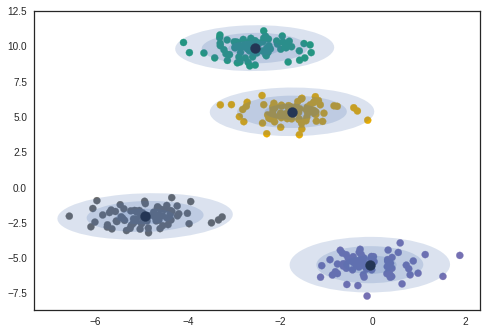

In [11]:
# initializes other parameters
pis_init = np.full(n_centers, 1 / n_centers) # same weights for all components
# same cov for all components derived from data
covs_init = np.full((n_centers, X.shape[1], X.shape[1]), np.cov(X, rowvar=False)) 
# run gmms with different initializations
mus, covs, pis, resp, converged, iterations = gmm_estimation(X, c_init, pis_init, covs_init, max_iter = 500) # random means
plot_gmm(X, mus, covs, pis, resp)

Plot 6 different GMMs

EM run 1 took 26 iterartions
EM run 2 took 109 iterartions
EM run 3 took 166 iterartions
EM run 4 took 27 iterartions
EM run 5 took 30 iterartions
EM run 6 took 38 iterartions


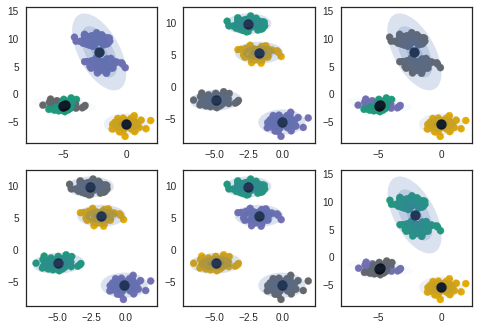

In [12]:
def plot_6_gmms(data, n_centers, center_init_fun):
    fig, axes = plt.subplots(2, 3)
    for i in range(6):
        c_init = center_init_fun(data, n_centers, i)
        pis_init = np.full(n_centers, 1 / n_centers)
        covs_init = np.full((n_centers, data.shape[1], data.shape[1]), np.cov(data, rowvar=False)) 
        means, covs, pis, resp, converged, iterations = gmm_estimation(data, c_init, pis_init, covs_init, max_iter = 500)
        plot_gmm(data, means, covs, pis, resp, axes[int(i/3), i%3])
        
        #log_likelihood = np.array([pis[k] * multivariate_normal(means[k], covs[k]).pdf(X) for k in range(n_centers)])
        #log_likelihood = np.log(log_likelihood).sum()
        #print("EM took %s iterartions and log likelihood %s " % (iterations, log_likelihood))
        print("EM run %s took %s iterartions" % (i+1, iterations))

plot_6_gmms(X, n_centers, random_centers)

The first, third and sixth iteration resulted in a not optimal solution. We see that the third has not coverged after the maximum amount of iterations. The estimated means are also not well calculated.

## k-Means++ Initialization
We already saw that the result for both k-Means and GMM depend strongly on the cluster center initialization. To get rid of this problem Arthur & Vassilvitskii came up with the k-means++ approach. The basic idea is...

In [13]:
def farthest_point_init(data, n_centers, seed=None):
    if (seed): 
        np.random.seed(seed)
    # choose first center randomly
    c_init = data[np.random.choice(range(data.shape[0]), size=1, replace=False)]
    # calculate distance to first center (this time use sklearn package)
    dist_to_centers = euclidean_distances(c_init, data, squared=True)
    n_data, _ = data.shape
    for i in range(1, n_centers):
        # choose next point that is farthest away from all centers
        c_init = np.append(c_init, data[np.argmax(dist_to_centers), np.newaxis], axis=0)
        # calculate distane to all centers and take minimum for each point's closest distance to a center
        if (i < n_centers-1):
            distances = euclidean_distances(c_init, data, squared=True)
            for j in range(distances.shape[0]):
                dist_to_centers = np.minimum(dist_to_centers, distances[j])

    return c_init

### k-means with k-means++

Run 1 has SSE 207.959465126 and took 2 iterations
Run 2 has SSE 207.959465126 and took 3 iterations
Run 3 has SSE 207.959465126 and took 2 iterations
Run 4 has SSE 207.959465126 and took 2 iterations
Run 5 has SSE 207.959465126 and took 2 iterations
Run 6 has SSE 207.959465126 and took 3 iterations


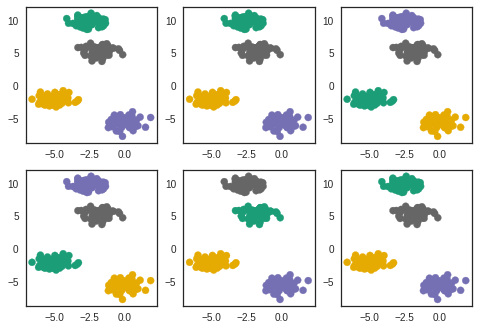

In [14]:
plot_6_kmeans(X, n_centers, farthest_point_init)

### GMM with k-means++

EM run 1 took 39 iterartions
EM run 2 took 43 iterartions
EM run 3 took 26 iterartions
EM run 4 took 36 iterartions
EM run 5 took 49 iterartions
EM run 6 took 53 iterartions


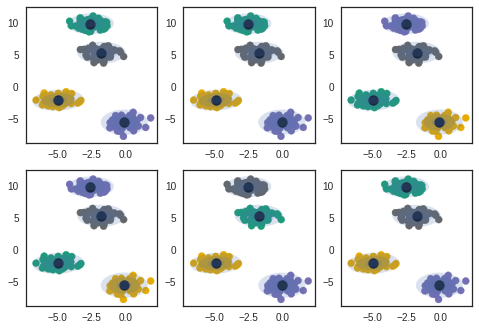

In [15]:
plot_6_gmms(X, n_centers, farthest_point_init)

Like proofen by Arthur & Vassilvitskii, we also see in this small sample size that we got optimal solutions in every case and needed fewer EM iterations as well. On the downside, the k-means++ needs more time to calculate proper initial cluster centers than in the random approach. 

## Elliptical Data Sets

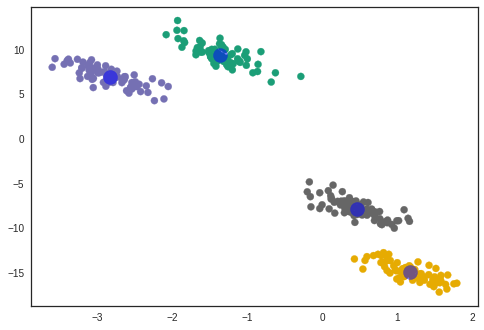

In [16]:
rs = np.random.RandomState(12)
X_ell = np.dot(X, rs.randn(2, 2))
true_centers = np.array([X_ell[y_true == i].mean(axis=0) for i in range(n_centers)])
plt.scatter(X_ell[:, 0], X_ell[:, 1], s=50, c=y_true)
plt.scatter(true_centers[:, 0], true_centers[:, 1], s=200, c='b', alpha=0.5)
plt.show()

Run 1 has SSE 370.801068805 and took 5 iterations
Run 2 has SSE 370.801068805 and took 5 iterations
Run 3 has SSE 370.801068805 and took 7 iterations
Run 4 has SSE 640.969735994 and took 4 iterations
Run 5 has SSE 370.801068805 and took 5 iterations
Run 6 has SSE 370.801068805 and took 5 iterations


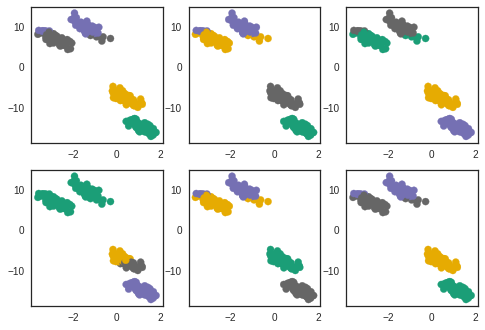

In [17]:
plot_6_kmeans(X_ell, n_centers, farthest_point_init)

EM run 1 took 38 iterartions
EM run 2 took 40 iterartions
EM run 3 took 35 iterartions
EM run 4 took 38 iterartions
EM run 5 took 39 iterartions
EM run 6 took 47 iterartions


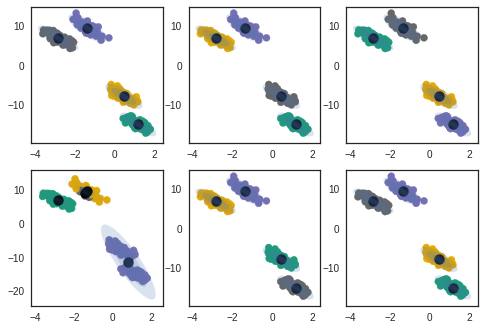

In [18]:
plot_6_gmms(X_ell, n_centers, farthest_point_init)

# Parallel Clustering

`ipyparallel` package has to be installed
```bash
pip install ipyparallel 
```

Start cluster using 4 cores locally with this command
```bash
ipcluster start -n 4 --log-to-file=True
```

Import ipyparallel package

In [22]:
import ipyparallel as ipp

## Parallel k-means

In [23]:
def kmeans_parallel(data, data_ref, center_init, view, max_iter = 100):
    n_data, n_feature = data.shape
    centers = center_init
    iterations = 0
    while True:
        iterations += 1
        # Run E-Step in parallel
        assignments = view.apply_sync(measure_distance, data_ref, centers)
        # Reshaping needed 
        assignments = np.array(assignments)
        assignments = assignments.reshape(n_data, n_feature+1)
        new_centers = relocate_centers(assignments, centers.shape[0])
        
        if (np.all(centers == new_centers)) or iterations == max_iter:
            break
        else:
            centers = new_centers
    
    # SSE
    errors = [np.sum(np.sum((assignments[:,1:][assignments[:,0] == i] - centers[i])**2)) for i in range(centers.shape[0])]
    errors = sum(errors)
          
    return centers, assignments, errors, iterations


rc = ipp.Client()
dview = rc[:]
dview2 = rc[-2:]
print("%s engines started" % len(rc.ids))


with dview.sync_imports():
    import numpy
%px np = numpy

4 engines started
importing numpy on engine(s)


In [24]:
# Measure sequential k-means performance
n_centers = 4
exponents = exponents = range(3, 6)
sample_sizes = np.concatenate((10**np.array(exponents), np.array(range(2, 11))*10**5))
time_results = []
for i, sample_size in enumerate(sample_sizes):
    data, _ = make_blobs(n_samples=sample_size, centers=n_centers, cluster_std=0.6, random_state=0)
    dview.scatter('data', data)
    dview2.scatter('data2', data)
    ref = ipp.Reference('data')
    ref2 = ipp.Reference('data2')
    c_init = farthest_point_init(data, n_centers)
    # sequential
    t_seq = %timeit -r 3 -o -q kmeans(data, c_init)
    time_results.append([1, sample_size, t_seq.best ])
    # parallel 2 cores
    t_par2 = %timeit -r 3 -o -q kmeans_parallel(data, ref2, c_init, dview2)
    time_results.append([2, sample_size, t_par2.best ])
    # parallel 4 cores
    t_par = %timeit -r 3 -o -q kmeans_parallel(data, ref, c_init, dview)
    time_results.append([4, sample_size, t_par.best ])

time_df = pd.DataFrame(data=time_results, columns=['cores', 'sample_size', 'time'])

In [25]:
time_df

cores  sample_size      time
0       1         1000  0.001558
1       2         1000  0.035509
2       4         1000  0.062489
3       1        10000  0.011041
4       2        10000  0.052951
5       4        10000  0.084877
6       1       100000  0.210831
7       2       100000  0.253407
8       4       100000  0.301348
9       1       200000  0.420922
10      2       200000  0.436555
11      4       200000  0.447650
12      1       300000  0.481358
13      2       300000  0.481992
14      4       300000  0.478306
15      1       400000  0.619208
16      2       400000  0.710046
17      4       400000  0.638871
18      1       500000  0.917979
19      2       500000  0.897263
20      4       500000  0.796329
21      1       600000  1.153789
22      2       600000  1.047693
23      4       600000  0.914740
24      1       700000  1.447831
25      2       700000  1.239662
26      4       700000  1.050149
27      1       800000  1.470282
28      2       800000  1.255412
29      4       800000  1.055200
30      1       900000  1.766114
31      2       900000  1.571795
32      4       900000  1.312811
33      1      1000000  2.074256
34      2      1000000  1.780365
35      4      1000000  1.448937

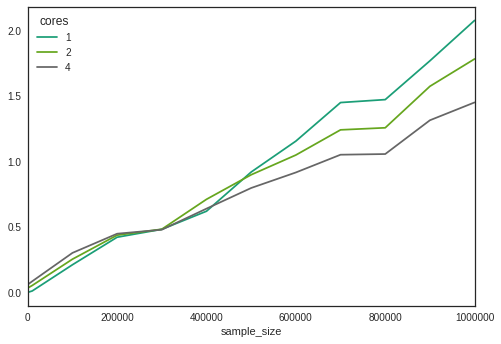

In [26]:
time_df.pivot(index='sample_size', columns='cores', values='time').plot(kind='line', colormap='Dark2')
plt.show()

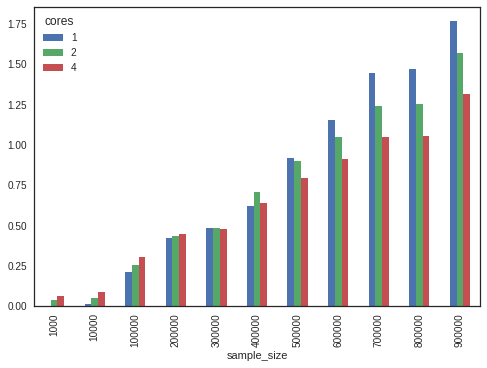

In [27]:
time_df[time_df.sample_size < 10**6].pivot(index='sample_size', columns='cores', values='time').plot(kind='bar')

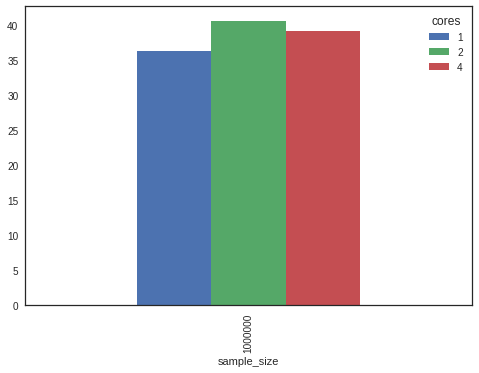

In [45]:
time_df[time_df.sample_size >= 10**6].pivot(index='sample_size', columns='cores', values='time').plot(kind='bar')

In [46]:
n_centers = 8
exponents = exponents = range(3, 6)
sample_sizes = np.concatenate((10**np.array(exponents), np.array(range(2, 11))*10**5))
time_results = []
for i, sample_size in enumerate(sample_sizes):
    data, _ = make_blobs(n_samples=sample_size, centers=n_centers, cluster_std=0.6, random_state=0)
    dview.scatter('data', data)
    dview2.scatter('data2', data)
    ref = ipp.Reference('data')
    ref2 = ipp.Reference('data2')
    c_init = farthest_point_init(data, n_centers)
    # sequential
    t_seq = %timeit -r 3 -o -q kmeans(data, c_init)
    time_results.append([1, sample_size, t_seq.best ])
    # parallel 2 cores
    t_par2 = %timeit -r 3 -o -q kmeans_parallel(data, ref2, c_init, dview2)
    time_results.append([2, sample_size, t_par2.best ])
    # parallel 4 cores
    t_par = %timeit -r 3 -o -q kmeans_parallel(data, ref, c_init, dview)
    time_results.append([4, sample_size, t_par.best ])

time_df = pd.DataFrame(data=time_results, columns=['cores', 'sample_size', 'time'])

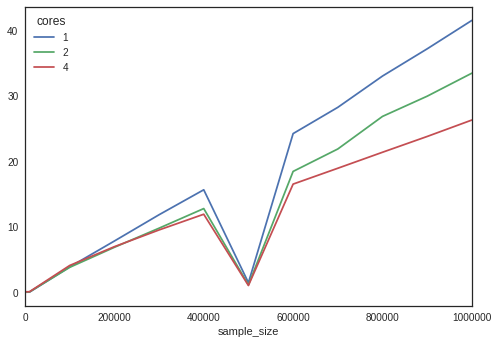

In [47]:
time_df.pivot(index='sample_size', columns='cores', values='time').plot(kind='line')
plt.show()

## Parallel GMM

In [31]:
def gmm_estimation_parallel(data, data_ref, centers_init, pis_init, covs_init, view, max_iter = 100):
    """
    Estimate GMM parameters by using EM algorithm
    
    Params
    data : array(n_data, n_features)
    data_ref : ipyparallel.Reference; reference to distributed data
    centers_init : array(n_centers, n_features); initial centers
    pis_init : array(n_centers,); initial center weights
    covs_init : array(n_centers, n_features, n_features); initial covariance matrix
    view : ipyparallel.DirectView: data view
    max_iter : int, Default=100; max. EM iterations 
    
    """
    n_data, n_feature = data.shape
    mus = centers_init
    covs = covs_init
    pis = pis_init
    k = mus.shape[0]
    iterations = 0
    converged = False
    while True:
        iterations += 1
        # parallel E-Step
        resp = view.apply_sync(calc_resposibility, data_ref, k, mus, covs, pis)
        # Reshape response
        resp = np.array(resp).reshape((n_data, n_feature + k))
        d, r = np.hsplit(resp, [n_feature])
        # M-Step
        pis_new, mus_new, covs_new = optimize_parameters(d, r.T, k)
        
        # check convergence
        converged = is_converged([pis_new, mus_new, covs_new], [pis, mus, covs])
        if iterations == max_iter or converged:
            break
        else:
            mus = mus_new
            pis = pis_new
            covs = covs_new
    
    return mus, covs, pis, resp, converged, iterations

importing numpy on engine(s)
importing multivariate_normal from scipy.stats on engine(s)


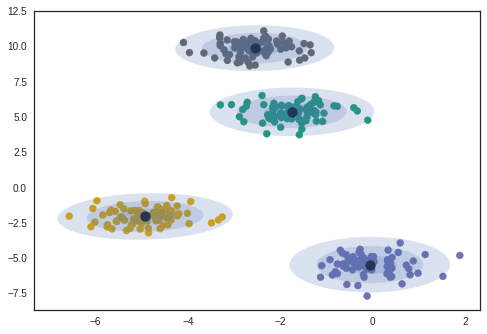

In [32]:
n_centers = 4
data, _ = make_blobs(n_samples=300, centers=n_centers, cluster_std=0.6, random_state=50)
c_init = farthest_point_init(data=data, n_centers=n_centers)
# initializes other parameters
pis_init = np.full(n_centers, 1 / n_centers) # same weights for all components
# same cov for all components derived from data
covs_init = np.full((n_centers, data.shape[1], data.shape[1]), np.cov(data, rowvar=False)) 

dview.clear(block=True)
dview.scatter('data', data)
ref = ipp.Reference('data')
with dview.sync_imports():
    import numpy
    from scipy.stats import multivariate_normal
%px np = numpy
# run gmms in parallel
mus, covs, pis, resp, converged, iterations = gmm_estimation_parallel(data, ref, c_init, pis_init, covs_init, dview, max_iter = 500) # random means
plot_gmm(data, mus, covs, pis, resp)

In [33]:
# Measure sequential k-means performance
n_centers = 4
sample_sizes = np.concatenate((10**np.array(exponents), np.array(range(2, 11))*10**5, np.array(range(2, 4))*10**6))
time_results = []
for i, sample_size in enumerate(sample_sizes):
    data, _ = make_blobs(n_samples=sample_size, centers=n_centers, cluster_std=0.6, random_state=0)
    dview.scatter('data', data)
    dview2.scatter('data2', data)
    ref = ipp.Reference('data')
    ref2 = ipp.Reference('data2')
    c_init = farthest_point_init(data, n_centers)
    pis_init = np.full(n_centers, 1 / n_centers) # same weights for all components
    covs_init = np.full((n_centers, data.shape[1], data.shape[1]), np.cov(data, rowvar=False)) 
    # sequential
    t_seq = %timeit -r 3 -o -q gmm_estimation(data, c_init, pis_init, covs_init)
    time_results.append([1, sample_size, t_seq.best ])
    # parallel 2 cores
    t_par2 = %timeit -r 3 -o -q gmm_estimation_parallel(data, ref2, c_init, pis_init, covs_init, dview2)
    time_results.append([2, sample_size, t_par2.best ])
    # parallel 4 cores
    t_par = %timeit -r 3 -o -q gmm_estimation_parallel(data, ref, c_init, pis_init, covs_init, dview)
    time_results.append([4, sample_size, t_par.best ])

time_df = pd.DataFrame(data=time_results, columns=['cores', 'sample_size', 'time'])

got unknown result: 102b2be0-699241cf3096b3645885c4e0
got unknown result: f8aeb5c2-05a0fa86ac6caac0cca7261a
got unknown result: 45431d96-fab12dabff341afe5494302f
got unknown result: c52d82aa-bb747b240395119e0ae3762b
got unknown result: 5ac79f2f-31720e4b587fece03b1e17c3
got unknown result: 0ed358cc-cb6761f402c9b6d4137210d8
got unknown result: 2f440db6-ecc4555c97d4ff7df1b69214


In [34]:
time_df

cores  sample_size       time
0       1         1000   0.016167
1       2         1000   0.126634
2       4         1000   0.227124
3       1        10000   0.067398
4       2        10000   0.227512
5       4        10000   0.308456
6       1       100000   0.503920
7       2       100000   0.813223
8       4       100000   1.035345
9       1       200000   1.160939
10      2       200000   1.548370
11      4       200000   2.111003
12      1       300000   1.487778
13      2       300000   1.914431
14      4       300000   2.533298
15      1       400000   1.976565
16      2       400000   2.318780
17      4       400000   2.701588
18      1       500000   2.854263
19      2       500000   3.298852
20      4       500000   3.928721
21      1       600000   3.425481
22      2       600000   3.874700
23      4       600000   4.429063
24      1       700000   3.997833
25      2       700000   4.330813
26      4       700000   5.075001
27      1       800000   3.345613
28      2       800000   3.547159
29      4       800000   3.964139
30      1       900000   4.447970
31      2       900000   4.626146
32      4       900000   5.099218
33      1      1000000   5.379871
34      2      1000000   5.467880
35      4      1000000   6.020159
36      1      2000000  13.146715
37      2      2000000  14.481833
38      4      2000000  14.710807
39      1      3000000  19.986373
40      2      3000000  25.352168
41      4      3000000  22.004775

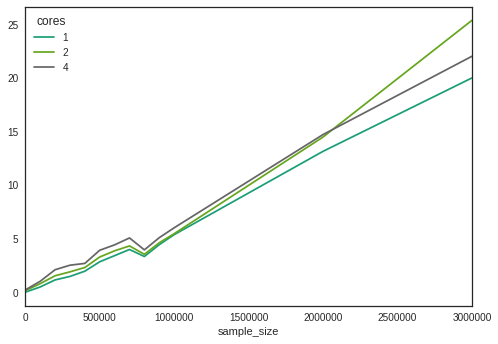

In [35]:
time_df.pivot(index='sample_size', columns='cores', values='time').plot(kind='line', colormap='Dark2')
plt.show()

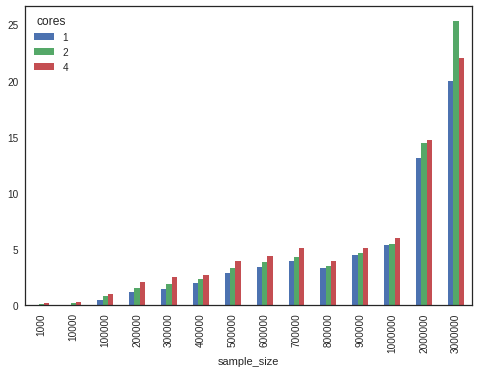

In [36]:
time_df.pivot(index='sample_size', columns='cores', values='time').plot(kind='bar')

In [37]:
n_centers = 8
sample_sizes = np.array([1*10**6])
time_results = []
for i, sample_size in enumerate(sample_sizes):
    data, _ = make_blobs(n_samples=sample_size, centers=n_centers, cluster_std=0.6, random_state=0)
    dview.scatter('data', data)
    dview2.scatter('data2', data)
    ref = ipp.Reference('data')
    ref2 = ipp.Reference('data2')
    c_init = farthest_point_init(data, n_centers)
    pis_init = np.full(n_centers, 1 / n_centers) # same weights for all components
    covs_init = np.full((n_centers, data.shape[1], data.shape[1]), np.cov(data, rowvar=False)) 
    # sequential
    t_seq = %timeit -r 3 -o -q gmm_estimation(data, c_init, pis_init, covs_init)
    time_results.append([1, sample_size, t_seq.best ])
    # parallel 2 cores
    t_par2 = %timeit -r 3 -o -q gmm_estimation_parallel(data, ref2, c_init, pis_init, covs_init, dview2)
    time_results.append([2, sample_size, t_par2.best ])
    # parallel 4 cores
    t_par = %timeit -r 3 -o -q gmm_estimation_parallel(data, ref, c_init, pis_init, covs_init, dview)
    time_results.append([4, sample_size, t_par.best ])

time_df = pd.DataFrame(data=time_results, columns=['cores', 'sample_size', 'time'])

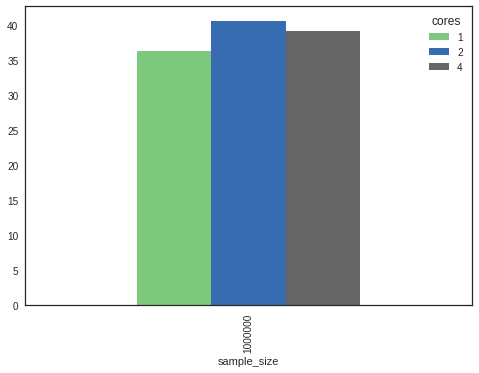

In [38]:
time_df.pivot(index='sample_size', columns='cores', values='time').plot(kind='bar', colormap='Accent')

## Image Compression with k-means

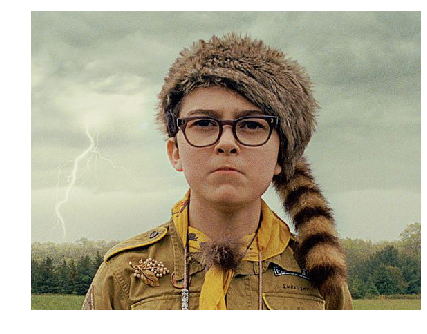

In [39]:
from skimage import io

image = io.imread('./moonrise-kingdom-2.jpg')
n_rows, n_cols, n_features = image.shape
with sns.axes_style('white'):
    plt.imshow(image)
    plt.axis('off')

data = image.reshape(n_rows * n_cols, n_features)

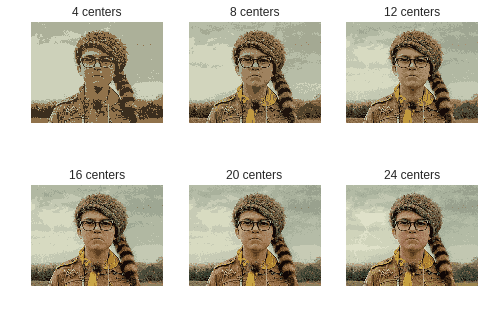

In [40]:
r = np.arange(4,25,4)
f, ax = plt.subplots(2, 3)
for i, k in enumerate(r):
    c_init = farthest_point_init(data=data, n_centers=k)
    centers, assignments, errors, iterations = kmeans(data=data, center_init=c_init)
    new_image = [centers[a, :] for a in assignments[:, 0]]
    new_image = np.array(new_image, dtype='uint8').reshape(n_rows, n_cols, n_features)
    with sns.axes_style('white'):
        ax[int(i/3), i%3].imshow(new_image)
        ax[int(i/3), i%3].set_title("%s centers" % k)
        ax[int(i/3), i%3].axis('off')
plt.show()

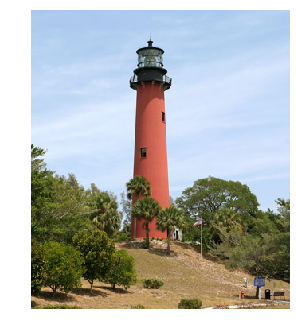

In [41]:
image = io.imread('./leuchtturm.jpg')
n_rows, n_cols, n_features = image.shape
data = image.reshape(n_rows * n_cols, n_features)
with sns.axes_style('white'):
    plt.imshow(image)
    plt.axis('off')

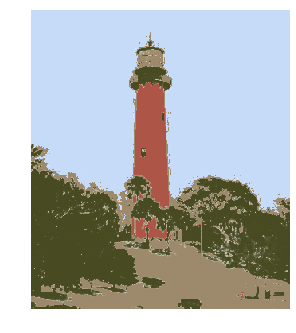

In [42]:
n_centers=4
c_init = farthest_point_init(data=data, n_centers=n_centers)
pis_init = np.full(n_centers, 1 / n_centers) # same weights for all components
covs_init = np.full((n_centers, data.shape[1], data.shape[1]), np.cov(data, rowvar=False)) 
centers, covariances, pis, resp, converged, _ = gmm_estimation(data=data, centers_init=c_init, covs_init=covs_init, pis_init=pis_init)

# for float dtype RGB values have to be between 0 and 1, therefore devide by max RGB value (255)
new_image = [np.column_stack(((centers[r.argmax(axis=0), :]/255).reshape(1, centers.shape[1]), r.max(axis=0))) for r in resp[:, -n_centers:]]
new_image = np.array(new_image, dtype='float').reshape(n_rows, n_cols, n_features+1)
new_image.astype('float')

with sns.axes_style('white'):
    plt.axis('off')
    plt.imshow(new_image)

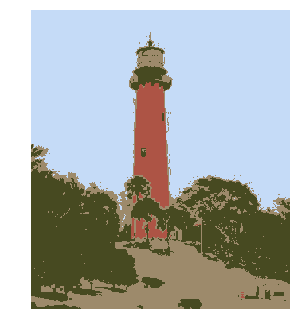

In [43]:
# without transparency value
with sns.axes_style('white'):
    plt.axis('off')
    plt.imshow(new_image[:, :, :3])